In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml



2023-12-05 15:10:44.133037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 15:10:44.909383: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 15:10:44.912625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 15:10:46.359178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(42)

# Set the path to the dataset
dataset_path = '.'

# Set the paths to images and annotations
images_folder = os.path.join(dataset_path, 'Images')
annotations_folder = os.path.join(dataset_path, 'Bounding_Boxes')

# Model configuration
input_shape = (512, 512, 3)  # Adjust based on your image size

In [3]:
class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax, class_id, img_path):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.class_id = class_id
        self.img_path = img_path

    def __repr__(self):
        return f'[{self.xmin}, {self.ymin}, {self.xmax}, {self.ymax} | {self.class_id}]'


In [4]:
# Data preprocessing and loading
def load_data():
    images = []
    annotations = []
    label_map = {}

    # Open Bounding_Boxes/darknet.labels and read class names and put into label_map
    with open(os.path.join(annotations_folder, 'darknet.labels'), 'r') as f:
        class_names = f.readlines()
        for i, class_name in enumerate(class_names):
            label_map[i] = class_name.strip()

    # return images, labels
    for annotation_name in os.listdir(annotations_folder):

        # If no .txt files, continue
        if not annotation_name.endswith('.txt'):
            continue

        # Load image
        image_name = annotation_name.replace('.txt', '.jpg')
        image_path = os.path.join(images_folder, image_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_width, original_image_height = image.shape[1], image.shape[0]
        image = cv2.resize(image, (input_shape[0], input_shape[1]))

        images.append(image)

        # Load annotations
        annotation_path = os.path.join(annotations_folder, annotation_name)
        with open(annotation_path, 'r') as f:
            # Parse bounding box coordinates and class label
            # Example format: class x_min y_min x_max y_max
            lines = f.readlines()
            sub_annotations = []
            for line in lines:
                line = line.strip().split(' ')
                class_label, x_center_relativ, y_center_relativ, width_relativ, height_relativ = map(float, line)

                # Convert normalized coordinates to absolute coordinates
                x_min = int((x_center_relativ - width_relativ / 2) * original_image_width)
                y_min = int((y_center_relativ - height_relativ / 2) * original_image_height)
                x_max = int((x_center_relativ + width_relativ / 2) * original_image_width)
                y_max = int((y_center_relativ + height_relativ / 2) * original_image_height)

                # Rescale coordinates to input_shape
                x_min = int(x_min * input_shape[0] / original_image_width)
                y_min = int(y_min * input_shape[1] / original_image_height)
                x_max = int(x_max * input_shape[0] / original_image_width)
                y_max = int(y_max * input_shape[1] / original_image_height)

                # Store annotation information
                sub_annotations.append(BoundingBox(x_min, y_min, x_max, y_max, int(class_label), image_path))

            annotations.append(sub_annotations)

    # images = np.array(images)

    return images, annotations, label_map


# Load and preprocess the data
images, annotations, label_map = load_data()

images, len(annotations), label_map


([array([[[229, 165,  65],
          [233, 169,  67],
          [236, 173,  69],
          ...,
          [229, 176,  57],
          [228, 177,  64],
          [232, 185,  92]],
  
         [[236, 172,  72],
          [231, 168,  65],
          [233, 170,  65],
          ...,
          [232, 178,  59],
          [226, 175,  62],
          [236, 186,  94]],
  
         [[238, 175,  71],
          [231, 168,  63],
          [226, 162,  56],
          ...,
          [228, 172,  54],
          [222, 169,  57],
          [235, 185,  93]],
  
         ...,
  
         [[235, 171,  71],
          [233, 169,  69],
          [232, 169,  66],
          ...,
          [236, 179,  61],
          [226, 175,  62],
          [238, 189,  99]],
  
         [[233, 171,  70],
          [236, 174,  72],
          [238, 176,  73],
          ...,
          [227, 171,  64],
          [229, 175,  80],
          [239, 188, 107]],
  
         [[230, 168,  67],
          [235, 173,  70],
          [238, 176,  72

In [5]:
annotations[0]


[[25, 48, 439, 61 | 1],
 [25, 61, 438, 73 | 1],
 [25, 74, 437, 86 | 1],
 [25, 87, 437, 98 | 1],
 [25, 98, 437, 111 | 1],
 [25, 112, 439, 122 | 1],
 [23, 122, 438, 135 | 1],
 [23, 136, 439, 148 | 1],
 [25, 186, 437, 197 | 1],
 [25, 197, 438, 209 | 1],
 [22, 209, 437, 222 | 1],
 [26, 263, 437, 274 | 1],
 [25, 274, 437, 286 | 1],
 [25, 288, 437, 299 | 1],
 [25, 342, 438, 352 | 1],
 [23, 352, 440, 364 | 1],
 [25, 365, 437, 377 | 1],
 [26, 417, 437, 430 | 1],
 [25, 430, 438, 441 | 1],
 [25, 439, 437, 466 | 1],
 [26, 466, 437, 478 | 1],
 [110, 159, 283, 171 | 0],
 [97, 236, 286, 250 | 0],
 [108, 312, 280, 327 | 0],
 [90, 389, 298, 405 | 0],
 [69, 22, 308, 36 | 0],
 [22, 16, 441, 151 | 2],
 [18, 160, 441, 234 | 2],
 [19, 233, 443, 304 | 2],
 [18, 308, 443, 385 | 2],
 [18, 388, 443, 482 | 2]]

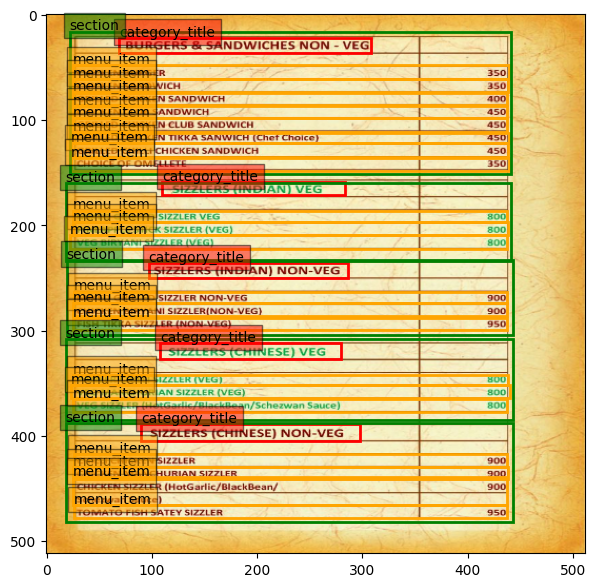

In [6]:
# Helper function to visualize bounding boxes
# It takes an image and a list of bounding boxes as inputs and plots an image with all the bounding boxes
# Each bounding box class should have a different color

color_map = {0: 'red', 1: 'orange', 2: 'green'}

def visualize_bounding_boxes(image, annotations):
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        xmin, ymin, xmax, ymax, class_id = annotation.xmin, annotation.ymin, annotation.xmax, annotation.ymax, annotation.class_id

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color_map[class_id], linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label_map[class_id], bbox=dict(facecolor=color_map[class_id], alpha=0.5))


plt.figure(figsize=(7, 7))

visualize_bounding_boxes(images[0], annotations[0])
plt.show()




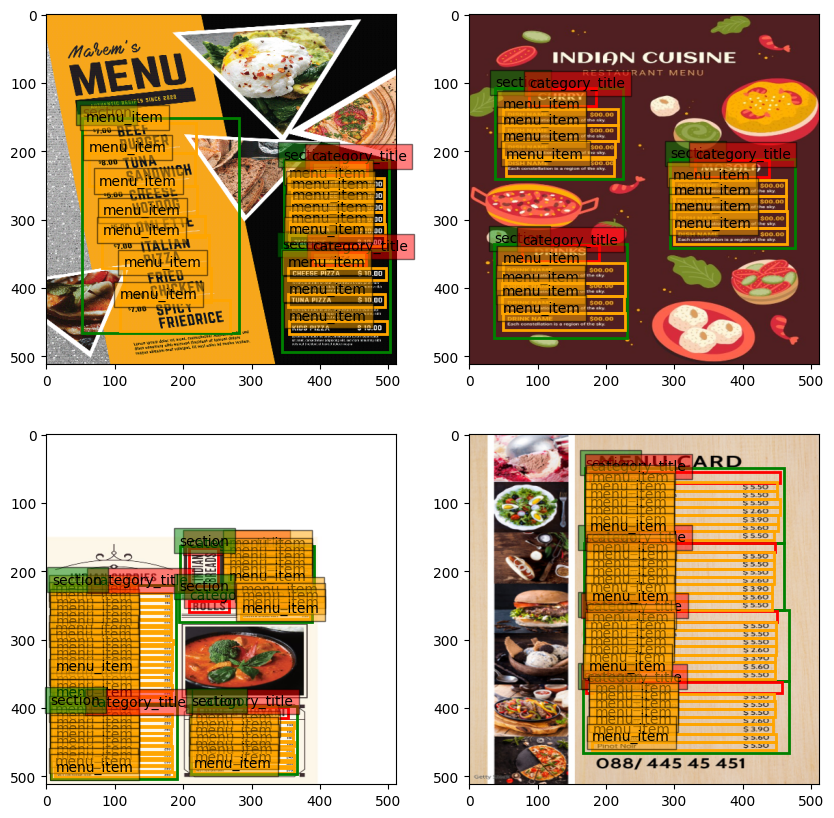

In [7]:
# Draw 4 randim images with bounding boxes in a 2x2 grid
plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    random_index = np.random.randint(len(images))
    visualize_bounding_boxes(images[random_index], annotations[random_index])
plt.show()

In [8]:
def create_dir_or_clean(path):
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(path):
        os.remove(os.path.join(path, file))

def save_images_and_txt_files(images, annotations, image_path, label_path, file_base_name):
    for i, (train_image, train_annotation) in enumerate(zip(images, annotations)):
        image_name = f'{file_base_name}_{i}.jpg'
        label_name = f'{file_base_name}_{i}.txt'

        # Write the image to disk using cv2. Keep in mind that the images are in RGB and cv2 uses BGR by default
        cv2.imwrite(os.path.join(image_path, image_name), cv2.cvtColor(train_image, cv2.COLOR_RGB2BGR))

        with open(os.path.join(label_path, label_name), 'w') as f:
            for annotation in train_annotation:
                f.write(f"{annotation[0]} {annotation[1]} {annotation[2]} {annotation[3]} {annotation[4]}\n")


In [9]:

# THis function has the following responsibilities:
# 1. Convert the annotations into the YOLO format
# 2. Split the data into train and validation sets
# 3. Save the data final_datasdet/images/train, final_datasdet/images/val and final_datasdet/labels/train, final_datasdet/labels/val
# 4. Save the label_map into final_datasdet/labels/darknet.labels
# 5. save the yolo configuration yaml file
def save_for_yolo_training(images, annotations):
    # Convert annotations into YOLO format
    yolo_annotations = []
    for sub_annotations in annotations:
        yolo_annotations.append([])
        for annotation in sub_annotations:
            x_center = (annotation.xmin + annotation.xmax) / 2
            y_center = (annotation.ymin + annotation.ymax) / 2
            width = annotation.xmax - annotation.xmin
            height = annotation.ymax - annotation.ymin

            # Normalize coordinates
            x_center /= input_shape[0]
            y_center /= input_shape[1]
            width /= input_shape[0]
            height /= input_shape[1]

            yolo_annotations[-1].append([annotation.class_id, x_center, y_center, width, height])

    # Split into train and validation sets
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, yolo_annotations, test_size=0.2, shuffle=True, random_state=42)

    # Create the directories
    image_train_path = 'final_dataset/images/train'
    image_val_path = 'final_dataset/images/val'
    label_train_path = 'final_dataset/labels/train'
    label_val_path = 'final_dataset/labels/val'
    create_dir_or_clean(image_train_path)
    create_dir_or_clean(image_val_path)
    create_dir_or_clean(label_train_path)
    create_dir_or_clean(label_val_path)

    # Save the images and labels
    save_images_and_txt_files(train_images, train_annotations, image_train_path, label_train_path, 'train')
    save_images_and_txt_files(val_images, val_annotations, image_val_path, label_val_path, 'val')

    # Copy the darknet.labels file to label train and val paths
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_train_path}')
    os.system(f'cp {os.path.join(annotations_folder, "darknet.labels")} {label_val_path}')

    # Create and save the yolo configuration file
    yolo_config = {
        'path': os.path.abspath('final_dataset'),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(label_map),
        'names': label_map,

    }
    yaml.dump(yolo_config, open('final_dataset/yolo_config.yaml', 'w'))


save_for_yolo_training(images, annotations)


In [10]:
from ultralytics import YOLO

model = YOLO("yolov8x.yaml").load("yolov8x.pt") # from local file

results = model.train(data = "./final_dataset/yolo_config.yaml", epochs = 12)



                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640

train: Scanning /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/train.cache... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<?, ?it/s]
val: Scanning /home/niklas/uni/semester7/dasc2/data-challenge-project/Menu_Card_Transformation/final_dataset/labels/val.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]


Plotting labels to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train6
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      15.2G      3.586      4.182      2.694         25        640: 100%|██████████| 2/2 [00:40<00:00, 20.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all          5        104      0.134     0.0833     0.0979     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      15.2G      2.885      4.077      2.404         70        640: 100%|██████████| 2/2 [00:38<00:00, 19.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]

                   all          5        104       0.13     0.0833      0.098     0.0587


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      15.1G      3.396      3.767      2.742         18        640: 100%|██████████| 2/2 [00:39<00:00, 19.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]

                   all          5        104      0.142     0.0687      0.093      0.052



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      16.7G      2.868      3.584      2.311         21        640: 100%|██████████| 2/2 [00:45<00:00, 22.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.05s/it]

                   all          5        104      0.112     0.0815     0.0791     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      16.7G      2.754      3.189      2.288         43        640: 100%|██████████| 2/2 [00:43<00:00, 21.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.30s/it]

                   all          5        104     0.0792      0.566     0.0758     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      16.7G       2.46      2.942      1.855         20        640: 100%|██████████| 2/2 [00:44<00:00, 22.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]

                   all          5        104     0.0735      0.311     0.0976     0.0259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      16.8G      2.411      2.296      1.802         15        640: 100%|██████████| 2/2 [00:45<00:00, 22.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.20s/it]

                   all          5        104      0.151      0.445      0.175     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      16.7G      1.996       2.11      1.752         20        640: 100%|██████████| 2/2 [00:41<00:00, 20.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.02s/it]

                   all          5        104     0.0647      0.157      0.043     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      16.8G      1.805      2.654      1.592          8        640: 100%|██████████| 2/2 [00:43<00:00, 21.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]

                   all          5        104      0.179      0.117     0.0743      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      15.7G      2.055      1.882      1.642         20        640: 100%|██████████| 2/2 [00:43<00:00, 21.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.23s/it]

                   all          5        104      0.282      0.228      0.144     0.0679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      16.7G      2.327          2      1.724         39        640: 100%|██████████| 2/2 [00:42<00:00, 21.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]

                   all          5        104      0.244      0.271      0.162     0.0767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      15.7G      1.911      2.023      1.545         14        640: 100%|██████████| 2/2 [00:41<00:00, 20.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]

                   all          5        104      0.214      0.319      0.154     0.0664



12 epochs completed in 0.171 hours.
Optimizer stripped from /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train6/weights/last.pt, 136.7MB
Optimizer stripped from /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train6/weights/best.pt, 136.7MB

Validating /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.8.10 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8192MiB)
YOLOv8x summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


                   all          5        104      0.241      0.267      0.162     0.0733
        category_title          5         15      0.367        0.4      0.277      0.126
             menu_item          5         77      0.234      0.234      0.139     0.0626
               section          5         12      0.122      0.167     0.0695     0.0314
Speed: 0.4ms preprocess, 814.0ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to /home/niklas/uni/semester7/dasc2/data-challenge-project/runs/detect/train6


In [11]:
# Load the model and make predictions on the validation set
model = YOLO("yolov8n.yaml").load("../runs/detect/train4/weights/best.pt") # from local file

image, annotation = images[0], annotations[0]

# Make predictions on the image
predictions = model(image)

predictions[0].boxes



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           


  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192,

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (512, 512)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))